In [1]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, GRU, Convolution1D,  MaxPooling1D, Flatten,Dense,Bidirectional,TimeDistributed,RepeatVector,ConvLSTM2D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc,classification_report,confusion_matrix,mean_squared_error,accuracy_score
from keras import optimizers
from itertools import cycle
import itertools
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler,ReduceLROnPlateau,TensorBoard
from keras.utils import plot_model
from datetime import datetime,timedelta
import warnings
import math
import tensorflow as tf
from keras import backend as K
warnings.filterwarnings('ignore')
sns.set()

Using TensorFlow backend.


In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
K.set_session(sess)

# 训练:验证:测试=3：1：1

In [14]:
callbacks_list = [TensorBoard(log_dir='./logs',histogram_freq=0),
                  EarlyStopping(monitor='acc',patience=10,),
                  ModelCheckpoint(filepath='lstm_model.h5',
                                  monitor='val_loss',save_best_only=True),
                  ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=10)]

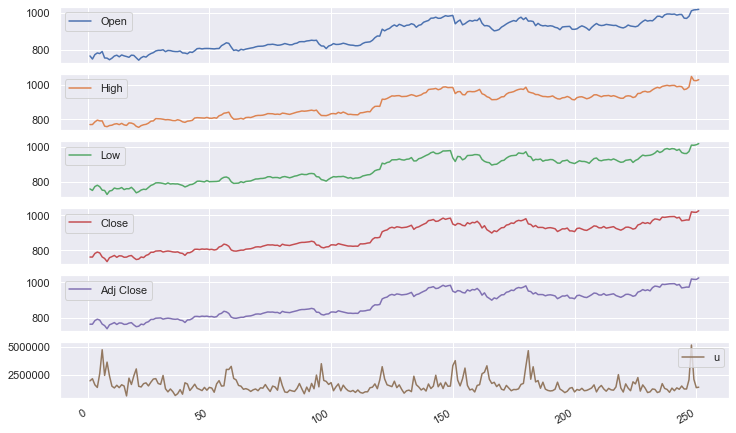

In [15]:
dir=r'C:\Users\USER\PycharmProjects\tf2\models\DL\dataset\GOOG-year.csv'
df=pd.read_csv(dir)
df_log=df.iloc[1:,:]
df_log.plot(subplots=True,figsize=(12,8))
plt.legend('upper left')

In [97]:
# 单步预测
# 1. 训练多个features,预测单个features
# 2. 训练多个features，预测多个features
class LSTM_model():
    def __init__(self,dirs,pre_fea):
        '''
        :param dir:
        :param pre_fea: 1  or 'all'
        '''
        self.layers=2
        self.units=128
        self.train_ratio = 0.6
        self.val_ratio = 0.2
        self.epoch = 100
        self.batch_size=16
        self.win_size = 5
        self.pre_next=1
        self.dir=dirs
        self.pre_fea=pre_fea

    def read_reg_preprocess(self):
        df = pd.read_csv(self.dir, engine='python')
        date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
        minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
        df_log = minmax.fit_transform(df.iloc[:, 1:].astype('float32'))
        df_log = pd.DataFrame(df_log)
        return date_ori, df, df_log, minmax

    def reshape_and_split(self,data,pre_fea_col):
        # 预测下一个时刻所有特征的值
        # 预测下一个时刻某个特征的值
        # 预测下n个时刻所有特征的值
        # 预测下n个时刻某个特征的值
        input_data_x = None
        input_data_y=None
        for k in range(0,data.shape[0]-1,self.pre_next):
            #index = min(k + win_size, data.shape[0]- 1)
            if k + self.win_size < data.shape[0]:
                one_batch_x = data.iloc[k:k + self.win_size,:]
                if self.pre_fea == 1:
                    one_batch_y = data.iloc[(k + self.win_size):(k + self.win_size+self.pre_next),pre_fea_col]  # 预测某列特征值
                else:
                    one_batch_y = data.iloc[(k + self.win_size):(k + self.win_size+self.pre_next),:]
                if input_data_x is None:
                    input_data_x = one_batch_x
                    input_data_y = one_batch_y
                else:
                    input_data_x = np.vstack((input_data_x, one_batch_x))
                    input_data_y = np.vstack((input_data_y, one_batch_y))
            else:
                break
        reshaped_data_x=input_data_x.reshape((k,self.win_size,data.shape[1]))
        reshaped_data_y = input_data_y.reshape((k, 1, data.shape[1]))
        return reshaped_data_x,reshaped_data_y

    def train_val_test_split(self,input_x,input_y):
        train_x=input_x[0:int((input_x.shape[0])*self.train_ratio)]
        val_x=input_x[int((input_x.shape[0])*self.train_ratio):int((input_x.shape[0])*(self.train_ratio+self.val_ratio))]
        test_x=input_x[int((input_x.shape[0])*(self.train_ratio+self.val_ratio)):]
        
        train_y=input_y[0:int((input_x.shape[0])*self.train_ratio)]
        val_y=input_y[int((input_x.shape[0])*self.train_ratio):int((input_x.shape[0])*(self.train_ratio+self.val_ratio))]
        test_y = input_y[int((input_x.shape[0])*(self.train_ratio+self.val_ratio)):]
        
        train_y=np.squeeze(train_y,1)
        val_y=np.squeeze(val_y,1)
        test_y=np.squeeze(test_y,1)
        return train_x,train_y,val_x,val_y,test_x,test_y

    def lstm_models(self,win_size,fea_size):
        model = Sequential()
        for l in range(1,self.layers):
            model.add(LSTM(self.units, input_shape=(win_size,fea_size),dropout=0.2, activation='relu',return_sequences=True))
        model.add(LSTM(self.units, input_shape=(win_size,fea_size),dropout=0.2, activation='relu'))
        model.add(Dense(fea_size, activation='sigmoid'))
        opt = optimizers.Adam(lr=0.001)
        model.compile(optimizer=opt, loss='mse',metrics=['accuracy'])
        model.summary()
        return model
    
    def convLSTM_models(self,bs,win_size,fea_size):
        model = Sequential()
        input_shape = (bs, win_size, fea_size, 1)
        model.add(ConvLSTM2D(16, kernel_size=(3, 3), activation='sigmoid', padding='same',input_shape=input_shape,return_sequences=True))
        model.add(ConvLSTM2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same',return_sequences=True))
        model.compile(loss='mse', optimizer='adam')


    def plot_train_val(self,history):
        fig = plt.figure(1)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper right')
        plt.show()

    def plot_pre(self,minmax,test_y,pred_y):
        pred_y_reverse = minmax.inverse_transform(pred_y)
        test_y_reverse = minmax.inverse_transform(test_y)
        fig = plt.figure(1)
        ax = plt.subplot(111)
        open_pred=pred_y_reverse[:,0] # 画open的预测结果
        open_test=test_y_reverse[:,0]
        ax.plot(open_pred,label='open pre')
        ax.plot(open_test,label='open test')
        plt.legend(loc='best')
        plt.grid(1)
        #plt.xticks(np.arange(len()))
        plt.show()

    def train_model(self,model,train_x,train_y,val_x,val_y):
        history = model.fit(train_x, train_y, nb_epoch=self.epoch, batch_size=self.batch_size,
                            verbose=2,validation_data=(val_x,val_y),callbacks=callbacks_list)  # callbacks=callbacks_list
        self.plot_train_val(history)
        
    def pre_test(self,model,test_x, test_y,minmax):
        pred_y = model.predict(test_x,verbose=2)
        # pred_y=minmax.inverse_transform(pred_y)
        rmse = math.sqrt(mean_squared_error(test_y, pred_y, ))  # multioutput='raw_values'  经计算每一列的均方误差
        print('Test RMSE: %.3f' % rmse)
        self.plot_pre(minmax, test_y, pred_y)

    def predict_and_plot(self,model,train_x,val_x,test_x,df,minmax):
        train_predict = model.predict(train_x)
        valid_predict = model.predict(val_x)
        test_predict = model.predict(test_x)
        
        train_pre_reverse = minmax.inverse_transform(train_predict)
        valid_pre_reverse = minmax.inverse_transform(valid_predict)
        test_pre_reverse = minmax.inverse_transform(test_predict)
        print(train_predict.shape,valid_predict.shape,test_predict.shape)
        
        open_train=train_pre_reverse[:,0] # 画open的预测结果
        open_val=valid_pre_reverse[:,0]
        open_test=test_pre_reverse[:,0]
        
        fig = plt.figure(figsize = (15, 10))
        #ax = plt.subplot(111)
        x_range_original = np.arange(df.shape[0])
        
        plt.plot(
            df.iloc[:, 1],
            label = 'true Open',
            color = 'b',)
        
        plt.plot(open_train,
            label = 'pred_train Open',
            color = 'g',)
        
        plt.plot([None for _ in open_train]+[x for x in open_val],
            label = 'pred_val Open',
            color = 'y',)
        
        plt.plot([None for _ in open_train]+[None for _ in open_val]+[x for x in open_test],
            label = 'pred_test Open',
            color = 'r',)
        
        plt.legend()
#         plt.title('Stock Price Prediction by attention-LSTM')
#         #plt.xticks(x_range_original[::30], date_ori[::30])
#         plt.show()

In [98]:
multi_use_LSTM=LSTM_model(dirs=dir,pre_fea='all') # 预测收盘价
date_ori,df,df_log,minmax=multi_use_LSTM.read_reg_preprocess()
input_x,input_y=multi_use_LSTM.reshape_and_split(df_log,pre_fea_col=1)
train_x,train_y,val_x,val_y,test_x,test_y = multi_use_LSTM.train_val_test_split(input_x,input_y)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 5, 128)            69120     
_________________________________________________________________
lstm_28 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 774       
Total params: 201,478
Trainable params: 201,478
Non-trainable params: 0
_________________________________________________________________
Train on 148 samples, validate on 49 samples
Epoch 1/100
 - 2s - loss: 0.0753 - accuracy: 0.1216 - val_loss: 0.0487 - val_accuracy: 0.2857
Epoch 2/100
 - 0s - loss: 0.0670 - accuracy: 0.0405 - val_loss: 0.0581 - val_accuracy: 0.0000e+00
Epoch 3/100
 - 0s - loss: 0.0538 - accuracy: 0.0270 - val_loss: 0.0756 - val_accuracy: 0.2857
Epoch 4/100
 - 0s - loss: 0.0343 - accuracy: 0

Epoch 79/100
 - 0s - loss: 0.0067 - accuracy: 0.6419 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 80/100
 - 0s - loss: 0.0067 - accuracy: 0.6216 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 81/100
 - 0s - loss: 0.0064 - accuracy: 0.6351 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 82/100
 - 0s - loss: 0.0075 - accuracy: 0.6351 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 83/100
 - 0s - loss: 0.0063 - accuracy: 0.6081 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 84/100
 - 0s - loss: 0.0072 - accuracy: 0.6824 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 85/100
 - 0s - loss: 0.0065 - accuracy: 0.5878 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 86/100
 - 0s - loss: 0.0069 - accuracy: 0.6351 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 87/100
 - 0s - loss: 0.0065 - accuracy: 0.6554 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 88/100
 - 0s - loss: 0.0071 - accuracy: 0.6351 - val_loss: 0.0120 - val_accuracy: 0.4082
Epoch 89/100
 - 0s - loss: 0.0064 - accuracy: 0.64

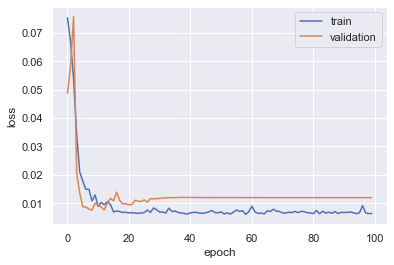

In [99]:
model=multi_use_LSTM.lstm_models(train_x.shape[1],train_x.shape[2])
# model=multi_use_LSTM.convLSTM_models(train_x.shape[0],train_x.shape[1],train_x.shape[2])
multi_use_LSTM.train_model(model,train_x,train_y,val_x,val_y)

Test RMSE: 0.138


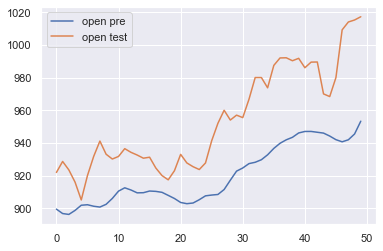

In [100]:
multi_use_LSTM.pre_test(model,test_x,test_y,minmax)

(148, 6) (49, 6) (50, 6)


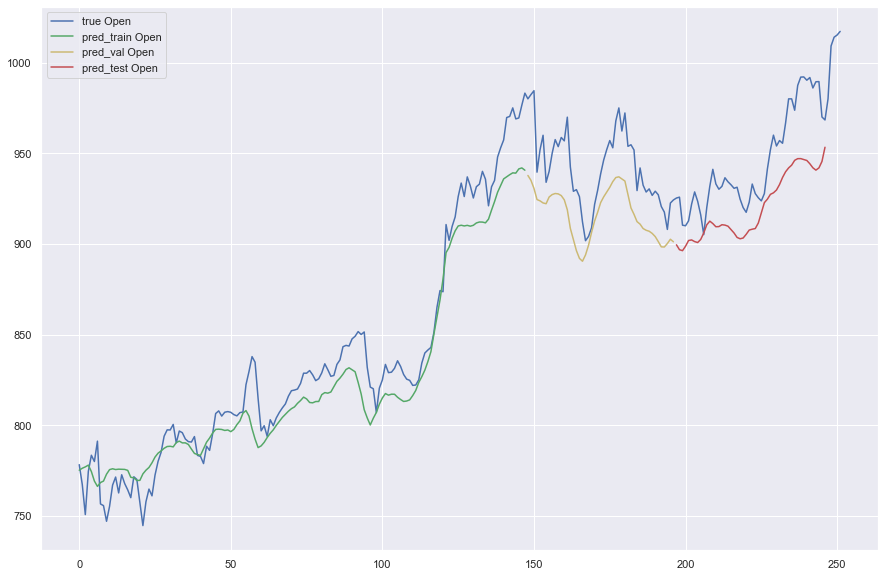

In [101]:
multi_use_LSTM.predict_and_plot(model,train_x,val_x,test_x,df,minmax)